# Demo MaskRCNN

A demo of the inner workings and potential of MaskRCNN

MaskRCNN is a state-of-the-art neural network architecture built for semantic segmentation and object classification. Here we demonstrate an implementation of MaskRCNN written entirely in JuliaLang, using Flux.jl, a differentiable programming library that provides an elegant framework to express entirely complex networks, close to how they were intended from scientific literature, without sacrificing performance.

We use Luxor.jl to help with demonstrating how our images are built and help us interpret the
results of the network more clearly. CuArrays.jl helps with running our model on the GPU with the use of powerful abstractions to point to an efficient GPU kernel.

In [128]:
using Luxor
# using CuArrays

include("maskrcnn.jl")

mold_inputs

We store a lot of the pretrained weights and such in the form of BSONs, as provided by BSON.jl. This makes it easy to move big data files around, especially with arbitrary data structures.

In [129]:
using BSON: @load, @save

COCO dataset has a number of classes; 81 in fact including planes, bats, cars, giraffes and people

MaskRCNN is a very complex model and has been developed to accomodate a large number of classifiers. We can use mulitplr ResNets, Inception models to act as a base classifier, wrapped around something known as a `Feature Pyramid Network` or `FPN` for short. The feature pyramid is designed to take the high level predictions given by the base classifier, transformed into a mapping to different layers of importance as understood by the spread of pixels they cover.

![title](https://cdn-images-1.medium.com/max/1600/1*QaPtdVXIeIdFhbW0Ac7tNA.png)

### Each section can be broken down further to their lower level components, but we can build the entire network with a call to a single function, and even configure it just how we need it. We use the default from the paper.

In [130]:
# Build the MaskRCNN model
c = build();

This is the canonical structure of our net.

![title](https://cdn-images-1.medium.com/max/1600/1*dYb3w2iVxkN7Ifx-eA8ZRg.jpeg)

Next we will pick a random image from the MS COCO dataset which was used to train the network. We will use this image as our test image and see how we perform. We also subsequently move the images over to the GPU to get them through our model.

In [131]:
coco = coco_annotations()
cid, images, classes = get_class_ids();

# Pick a random image and its attributes from COCO dataset
image, image_metas, gt_class_ids, gt_boxes, gt_masks = load_image_gt(cid, images, classes);

# Moving the data over to the GPU
image = Float32.(reshape(image, (size(image)..., 1))) |> gpu
gt_masks = gpu(gt_masks)
gt_boxes = gpu(gt_boxes)

9×4 Array{Integer,2}:
 308  213  611  367
 360    1  609  122
 414  363  811  497
 521    6  929  285
 359  107  843  190
 293  340  830  425
 365  176  435  187
 215  256  296  262
 555  334  647  375

We can now run our image through the network, which is exposed as a variation of the simple `predict` function. The current model we use is using pretrained weights, trained earlier on a Tesla K40.

There are two stages of Mask RCNN. First, it generates proposals about the regions where there might be an object based on the input image. Second, it predicts the class of the object, refines the bounding box and generates a mask in pixel level of the object based on the first stage proposal. Both stages are connected to the backbone structure, which is the ResNet 101 in our case.

In [ ]:
boxes, masks = predict(c, image, image_metas);

In [144]:
# image = readpng("img.png")
@load "boxes2.bson" boxes

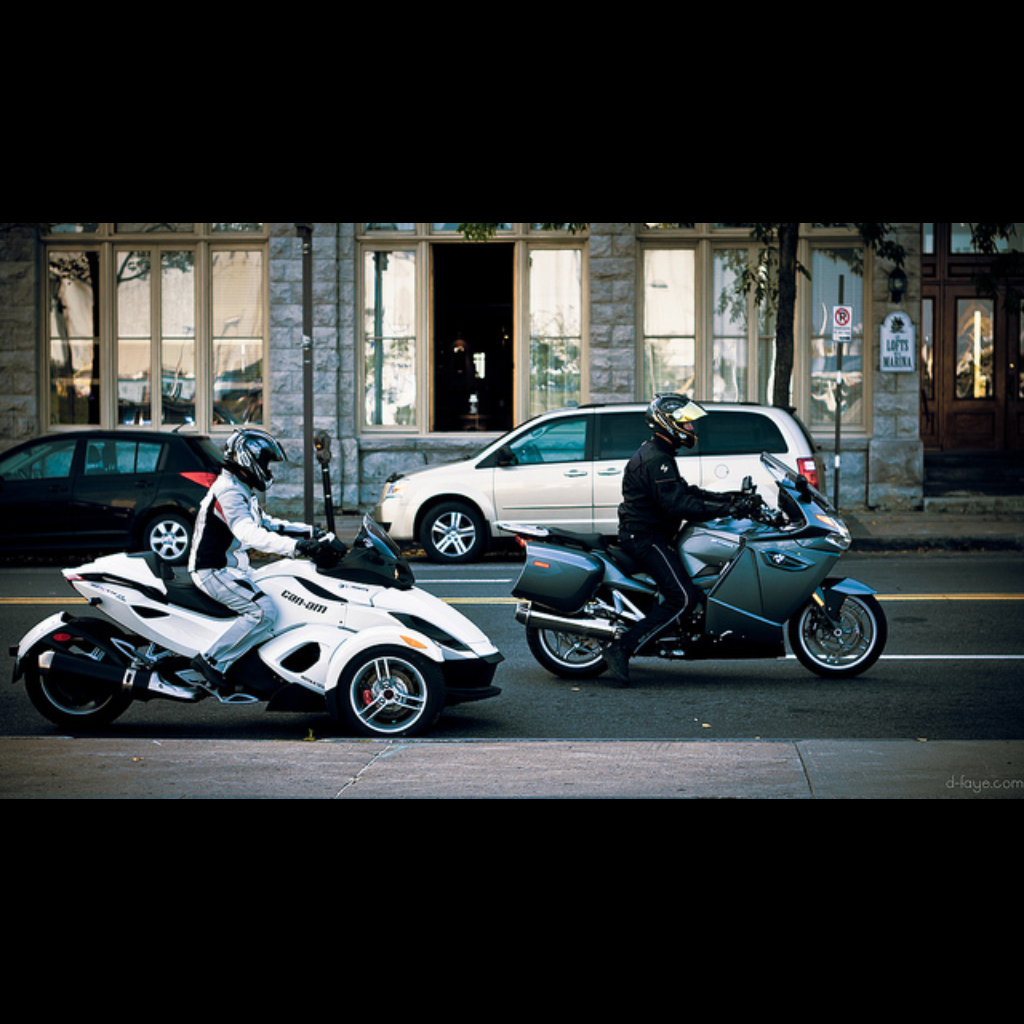

In [95]:
image

The predictions from this image can be seen in the matrix below. They point directly to the bounding boxes that may have objects, collected from all of the categories in our dataset.

In [145]:
boxes

55×6 Array{Float32,2}:
   1.0  800.0   368.0  800.0  1.0  0.999928
 835.0  800.0  1025.0  800.0  1.0  0.99992 
 836.0  224.0  1025.0  224.0  1.0  0.999905
 368.0  800.0   758.0  800.0  1.0  0.999881
 610.0  224.0   777.0  224.0  1.0  0.999646
 461.0  224.0  1025.0  604.0  1.0  0.999575
 138.0  660.0   652.0  800.0  1.0  0.999125
 310.0  224.0   663.0  253.0  1.0  0.999084
 110.0  224.0   414.0  563.0  1.0  0.999082
   1.0  676.0   194.0  800.0  1.0  0.999055
 662.0  224.0  1014.0  285.0  1.0  0.999052
 871.0  419.0  1025.0  800.0  1.0  0.999052
 566.0  420.0   919.0  701.0  1.0  0.999037
   ⋮                               ⋮       
 940.0  795.0  1025.0  800.0  1.0  0.998857
 874.0  224.0  1025.0  363.0  1.0  0.998683
   1.0  800.0    77.0  800.0  1.0  0.998571
 742.0  800.0   903.0  800.0  1.0  0.989739
 359.0  224.0   618.0  398.0  1.0  0.98788 
 277.0  800.0   506.0  800.0  1.0  0.969298
 201.0  224.0   443.0  234.0  1.0  0.894217
 554.0  224.0   798.0  402.0  1.0  0.854086
 684.0  2

A lot of the times smaller boxes fill in to account for the objects that are really small and non part of the objects we are generally interested in (our subjects). Also, we train on our images flipped for standardising different parts of the pipeline, and so need to account for that.

In [149]:
# For Luxor:
# x1, y1, x2, y2

# For MaskRCNN
# y1, x1, y2, x2

# Filter the small boxes and draw bounding boxes
pts = []
thresh = 80000
for i = 1:size(boxes, 1)
    box = boxes[i,:]
    area = (box[4] - box[2]) * (box[3] - box[1])
    if area > thresh
        # The images are trained rotated 180° counter-clockwise
        # So the results are supposed to be flipped over
        # to get the correct boxes
        push!(pts, [Point(box[1], 1024 - box[2]), Point(box[3], 1024 - box[4])])
    end
end

Next, we draw the resultant image to see how we've done.

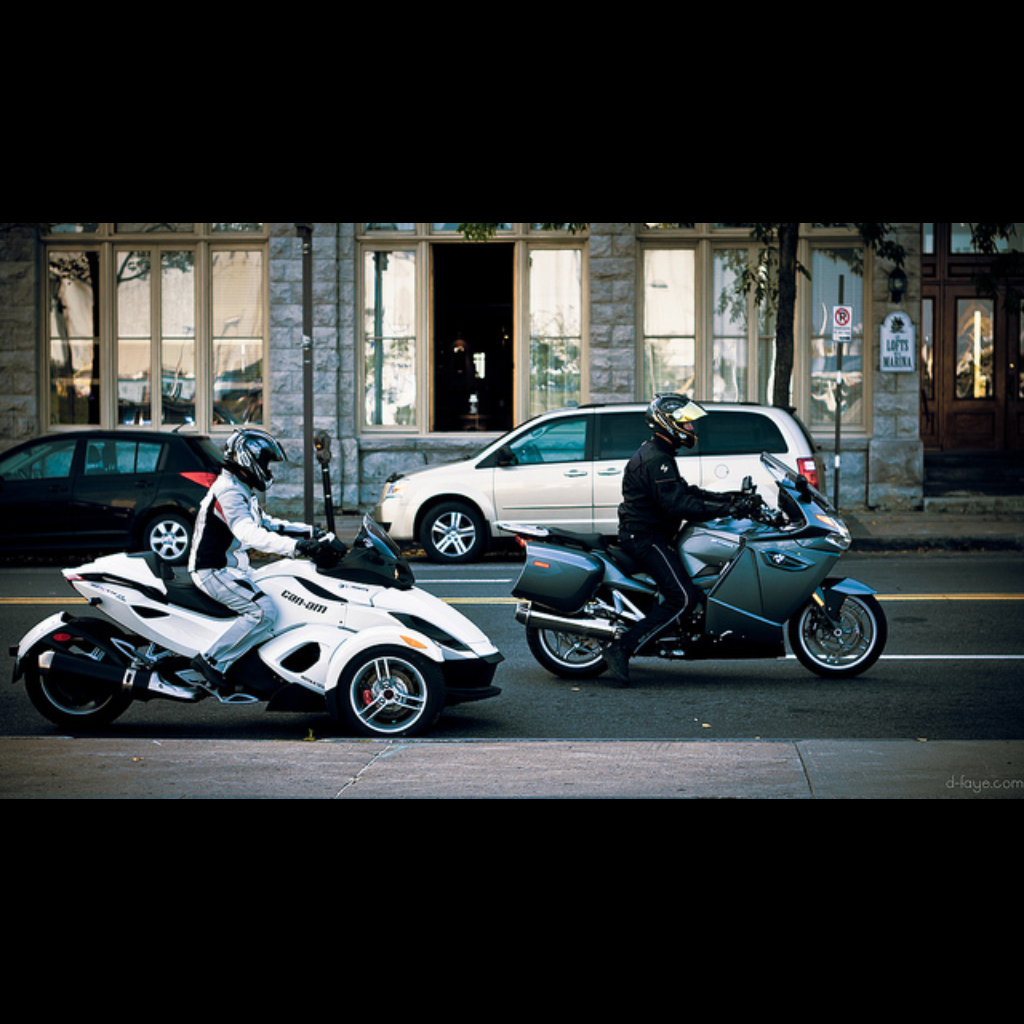

In [138]:
image = readpng("img.png")

In [150]:
w = image.width
h = image.height
fname = "bbox_trial.png"
Drawing(w, h, fname)
background("black")
setline(1.5)
sethue("white")
for pt in pts
    box(pt[1], pt[2], :stroke)
end
placeimage(image, 0, 0, 0.4)


finish()

true

#### Note that the model output is post being transfer learned on a separate dataset, details follow

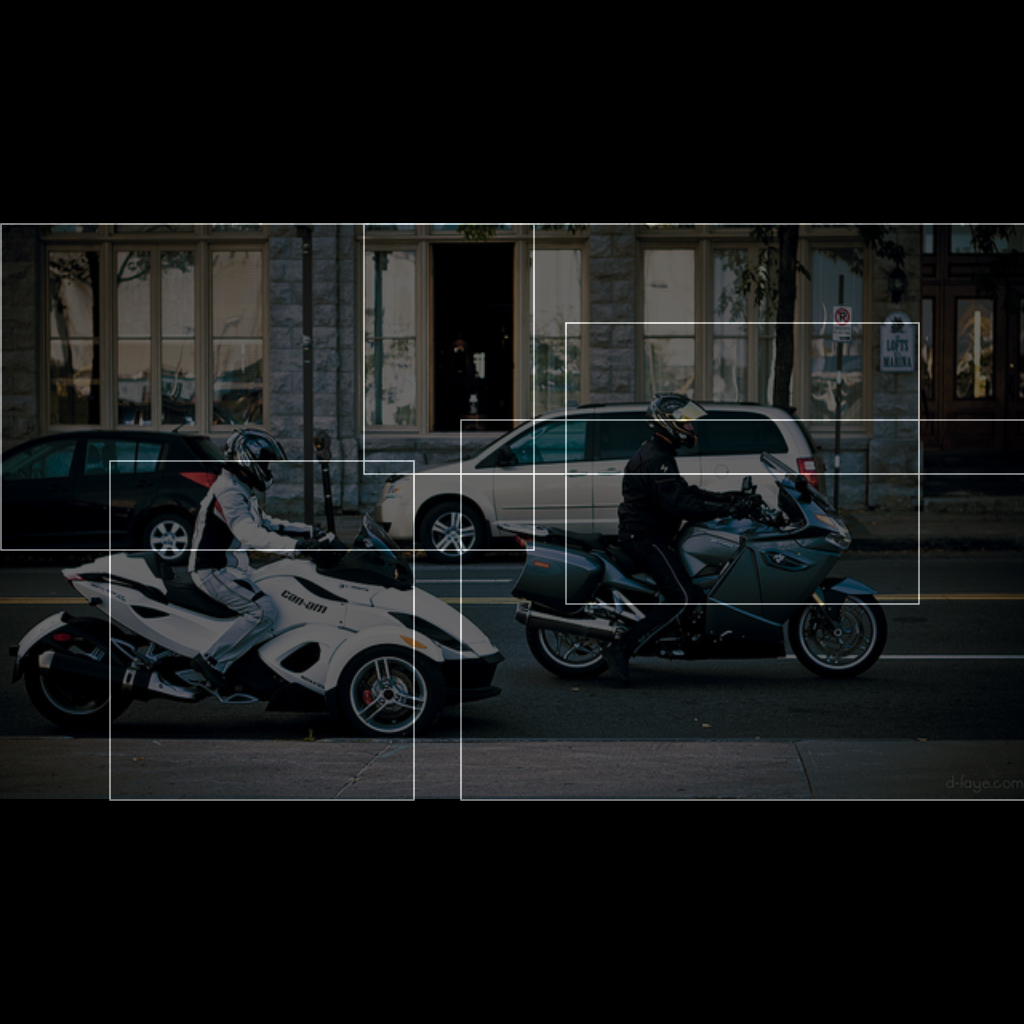

In [151]:
readpng(fname)

# Disaster Detection
### Change Detection

The neural network was trained on images from COCO as well as some from images of wildfires, simulating regions struck with wildfires, as an example. This can be further extrapolated by simply training the net with instances of situations we would like it to detect.

We annotated the images using VGG Image Annotator (VIA) to perform transfer learning, and train MaskRCNN.

An example of annotation is as described below. We can further use this to send to our API to get everything set up for training as well as inferring. This is convenient and clean to set up. 

Let us first look at the image we will use to infer the net from.

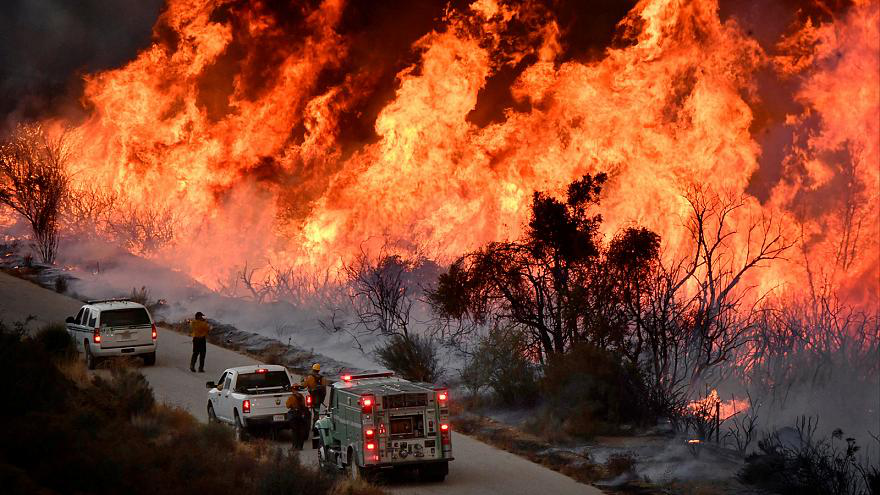

In [70]:
fire = readpng("fire2.png")

The procedure is the same as before, we take an image, make it in a format the net can infer with, and pass it on.

In [125]:
all_points_x = [7,37,64,85,92,81,87,151,166,337,349,463,546,565,609,634,718,763,873,878,739,662,652,615,538,523,447,345,248,181,59,7];
all_points_y = [137,121,123,123,105,104,78,48,6,3,149,2,5,64,48,3,2,48,3,324,334,255,223,225,192,242,272,275,296,281,228,139];

segmentation = zeros(Float32, length(all_points_x) + length(all_points_y));
segmentation[1:2:end] = all_points_y;
segmentation[2:2:end] = all_points_x;

In [ ]:
image, image_metas, gt_class_ids, gt_boxes, gt_masks = load_image_gt("fire2.jpg", [segmentation], [5])

image = Float32.(reshape(image, (size(image)..., 1))) |> gpu

In [ ]:
boxes, masks = predict(c, fire, image_metas);

In [157]:
@load "boxes_fire2_1.bson" boxes

In [158]:
boxes

13×6 Array{Float32,2}:
 742.0  224.0  1022.0  498.0  6.0  1.0     
   2.0  674.0   475.0  800.0  6.0  0.8722  
 712.0  691.0  1025.0  800.0  6.0  0.782783
   1.0  224.0   354.0  514.0  1.0  0.780296
 153.0  224.0  1020.0  544.0  1.0  0.770363
   1.0  224.0   280.0  655.0  1.0  0.753087
   1.0  713.0   236.0  800.0  1.0  0.752489
 673.0  224.0  1023.0  368.0  1.0  0.740684
   1.0  224.0   251.0  319.0  1.0  0.7375  
   2.0  524.0   345.0  800.0  6.0  0.679132
   4.0  475.0   745.0  800.0  6.0  0.660614
 483.0  322.0  1024.0  800.0  1.0  0.654033
 560.0  525.0  1025.0  800.0  6.0  0.581458

In [159]:
pts = []
probs = []
thresh = 180000
for i = 1:size(boxes, 1)
    box = boxes[i,:]
    area = (box[4] - box[2]) * (box[3] - box[1])
    if area > thresh
        # The images are trained rotated 180° counter-clockwise
        # So the results are supposed to be flipped over
        # to get the correct boxes
        push!(pts, [Point(box[1], 495 - box[2]), Point(box[3], 495 - box[4])])
        push!(probs, box[6])
    end
end

In [160]:
w = fire.width
h = fire.height
fname = "fire_trial.png"
Drawing(w, h, fname)
background("black")
setline(1.5)
sethue("white")
for (i,pt) in enumerate(pts)
    fontsize(20)
    text(string(probs[i]), pt[1] - 4, halign = :top)
    box(pt[1], pt[2], :stroke)
end
placeimage(fire, 0, 0, 0.4)


finish()

true

We can now take a look at what our net has output, and the results look promising, we have picked out regions with fire in them, but it isn't perfect. We have definitely been able to identify the disaster which is what we set out to do, and can use this as a starting point to record how it evolves over time, as well as alert the respective bodies to take the relevant actions as necessary.

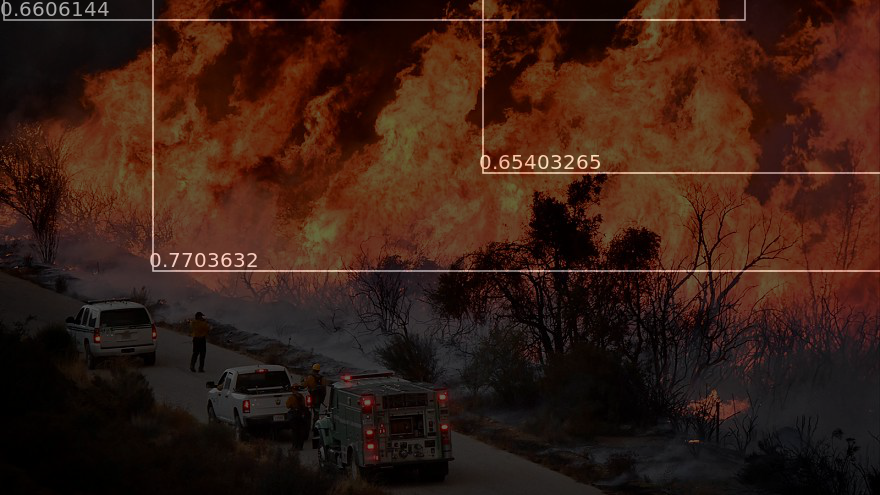

In [161]:
readpng(fname)

# Slum Detection

In [199]:
@load "boxes16.bson" boxes

In [200]:
boxes

100×6 Array{Float32,2}:
 175.0  277.0   468.0  666.0  6.0  0.999885
 794.0  245.0  1019.0  578.0  6.0  0.999736
 282.0  202.0   875.0  759.0  6.0  0.999681
  24.0  202.0   362.0  516.0  6.0  0.999675
 250.0  202.0   586.0  384.0  6.0  0.999466
   1.0  202.0   241.0  202.0  6.0  0.999285
 536.0  202.0   874.0  292.0  6.0  0.999223
 556.0  202.0   854.0  508.0  6.0  0.998987
 294.0  607.0   538.0  823.0  6.0  0.99886 
 318.0  412.0   642.0  733.0  6.0  0.998738
 476.0  570.0   804.0  823.0  6.0  0.998722
 785.0  202.0  1018.0  317.0  6.0  0.998721
 817.0  759.0  1019.0  823.0  6.0  0.998721
   ⋮                               ⋮       
 170.0  202.0   227.0  202.0  1.0  0.979081
 356.0  254.0   755.0  525.0  1.0  0.973164
   1.0  202.0   341.0  369.0  1.0  0.966764
 386.0  202.0   797.0  350.0  1.0  0.965638
 380.0  202.0   579.0  217.0  1.0  0.958691
 711.0  202.0  1025.0  456.0  1.0  0.958032
 327.0  202.0   642.0  247.0  1.0  0.957481
  78.0  671.0   312.0  823.0  1.0  0.927423
 209.0  

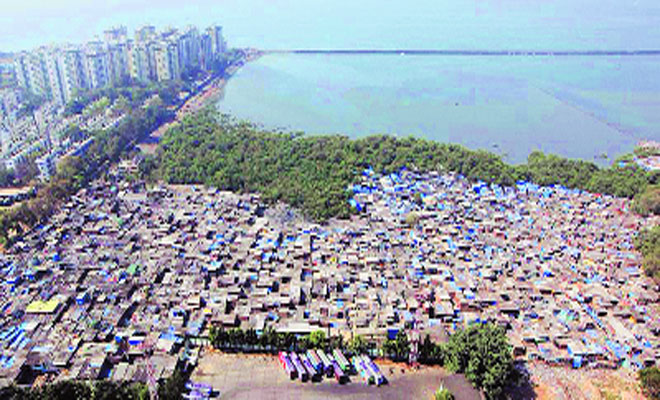

In [173]:
slum = readpng("slum4.png")

In [262]:
pts = []
probs = []
thresh = 180000
for i = 1:size(boxes, 1)
    box = boxes[i,:]
    area = (box[4] - box[2]) * (box[3] - box[1])
    if area > thresh
        # The images are trained rotated 180° counter-clockwise
        # So the results are supposed to be flipped over
        # to get the correct boxes
        push!(pts, [Point(box[1], box[2]), Point(box[3], box[4])])
        push!(probs, box[6])
    end
end

In [263]:
w = slum.width
h = slum.height
fname = "slum_trial.png"
Drawing(w, h, fname)
background("black")
setline(1.5)
sethue("white")
for (i,pt) in enumerate(pts)
    fontsize(20)
    text(string(probs[i]), pt[1] - 4, halign = :top)
    box(pt[1], pt[2], :stroke)
end
placeimage(slum, 0, 0, 0.4)


finish()

true

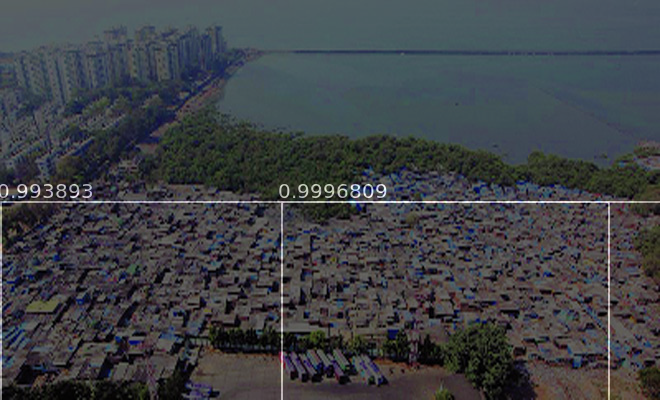

In [264]:
readpng("slum_trial.png")